# Assignment 2 : Language Modeling & Evaluation 

**Student names**: Ramtin Forouzandehjoo Samavat <br>
**Group number**: 30 <br>
**Date**: 22.09.2025

## Important notes
Please read and follow these rules. Submissions that do not fulfill them may be returned.
1. You may work in groups of maximum 2 students.
2. Submit in **.ipynb** format only.
3. The assignment must be typed. Handwritten answers are not accepted.

**Due date**: 28.09.2025 23:59

### What you will do
- Build a **unigram document language model** with a **document-term matrix**.
- Rank documents for queries using **Jelinek-Mercer smoothing**.
- Evaluate the run using **Cranfield queries and qrels** (P@k, MAP, MRR).
- (Optional) Try **Dirichlet** and compare briefly.


---
## Dataset

Make sure the Cranfield files are placed next to the notebook:
- `cran.all.1400` — document collection (1400 docs)
- `cran.qry` — queries
- `cranqrel` — relevance judgments (qrels)

> Only the **document parsing** for cran.all.1400 code is provided below. You will implement the rest in the TODO cells.


### Load and parse documents (provided)

Run the cell to parse the Cranfield documents. Update the path so it points to your `cran.all.1400` file.


In [61]:
from numpy.ma.extras import column_stack

# TODO: Read 'cran.all.1400' and parse the documents into a suitable data structure

CRAN_PATH = r"cran.all.1400"  # <-- change this!

def parse_cranfield(path):
    docs = {}
    current_id = None
    current_field = None
    buffers = {"T": [], "A": [], "B": [], "W": []}
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.rstrip("\n")
            if line.startswith(".I "):
                if current_id is not None:
                    docs[current_id] = {
                        "id": current_id,
                        "title": " ".join(buffers["T"]).strip(),
                        "abstract": " ".join(buffers["W"]).strip()
                    }
                current_id = int(line.split()[1])
                buffers = {k: [] for k in buffers}
                current_field = None
            elif line.startswith("."):
                tag = line[1:].strip()
                current_field = tag if tag in buffers else None
            else:
                if current_field is not None:
                    buffers[current_field].append(line)
    if current_id is not None:
        docs[current_id] = {
            "id": current_id,
            "title": " ".join(buffers["T"]).strip(),
            "abstract": " ".join(buffers["W"]).strip()
        }
    print(f"Parsed {len(docs)} documents.")
    return docs

documents = parse_cranfield(CRAN_PATH)
print(list(documents.items())[:1])  # peek at the first parsed doc


Parsed 1400 documents.
[(1, {'id': 1, 'title': 'experimental investigation of the aerodynamics of a wing in a slipstream .', 'abstract': 'experimental investigation of the aerodynamics of a wing in a slipstream .   an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem .   the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary-layer-control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory .   an empirical evaluation of the destalling effects was made fo

## 2.1 Language Modeling

You will create a **unigram language model** per document, using a **document-term matrix**, and score queries with **Jelinek-Mercer smoothing**.


### 2.1.1 Preprocessing

Implement a simple tokenizer/normalizer (e.g., lowercasing, punctuation removal and stopword removal) and apply it to each document

- Return a list of tokens for each document.


In [62]:
# TODO: Implement preprocessing and apply to all documents

STOPWORDS = set("""a about above after again against all am an and any are aren't as at be because been
before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down
during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers
herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most
mustn't my myself no nor not of off on once only or other ought our ours ourselves out over own same shan't she
she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's
these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're
we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't
you you'd you'll you're you've your yours yourself yourselves""".split())

# Your code here

import re

def tokenize(text, stopwords):
  tokens = re.findall(r"\b[a-z]+\b", text.lower()) # Convert to lowercase and remove all non-alphabetic characters.
  tokens = [word for word in tokens if word not in stopwords] # Only keep words that are not stopwords.
  return tokens

document_tokens = {} # Dictionary<doc_id, token> to store each token.
for doc_id, doc in documents.items():
  combined_text = f"{doc['title']} {doc['abstract']}"
  document_tokens[doc_id] = tokenize(combined_text, STOPWORDS)

# Check if done correctly.
for i in range(1, 2):
  print(f"Doc {i}: {document_tokens[i][:30]} ...")

Doc 1: ['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream', 'experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream', 'experimental', 'study', 'wing', 'propeller', 'slipstream', 'made', 'order', 'determine', 'spanwise', 'distribution', 'lift', 'increase', 'due', 'slipstream', 'different', 'angles', 'attack', 'wing', 'different', 'free'] ...


### 2.1.2 Build the matrix

Construct:
- A vocabulary `term -> column_index`
- A (sparse) **document–term count matrix**
- Document lengths `|d|` and collection (all documents) totals

> Tip: You may use dictionaries or `scipy.sparse` for efficiency.


In [63]:
# TODO: Build vocabulary, doc-term counts (sparse), document lengths, and collection totals
# Your code here

import numpy as np
from scipy.sparse import lil_matrix

# Creating a vocabulary.
vocabulary = set() # Will only keep unique tokens.
for tokens in document_tokens.values():
  vocabulary.update(tokens) # Add each unique term from each token to the vocabulary.

# Turn it to a dictionary that maps terms and column index in the document matrix.
vocabulary = {term: index for index, term in enumerate(sorted(vocabulary))}

print(f"Number of terms in the vocabulary: {len(vocabulary)}")


# Creating document-term matrix

number_documents = len(document_tokens)
number_tokens = len(vocabulary)

dtm = lil_matrix((number_documents, number_tokens)) # Creates a number_docs x number_tokens empty matrix.

# Fill the matrix.
for doc_id, tokens in document_tokens.items():
    for term in tokens:
        if term in vocabulary:  # just a safeguard, should always be true.
            column_index = vocabulary[term] # Retrieve the column index based on the term.
            # [doc_id - 1] - matrices are 0-indexed, while doc_id start at 1.
            dtm[doc_id - 1, column_index] += 1 # Add one for each occurrence of the term.

dtm = dtm.tocsr()

print("Dtm shape:", dtm.shape)
print("Number of stored elements in dtm:", dtm.nnz)
print("Dtm density:", dtm.nnz / (dtm.shape[0] * dtm.shape[1]))


document_lengths = np.array(dtm.sum(axis=1)).flatten() # Sum of each row in the matrix.
collection_length = document_lengths.sum() # total number of sum of all document lengths
collection_frequencies = np.array(dtm.sum(axis=0)).flatten()  # Collection frequency for each term

Number of terms in the vocabulary: 6928
Dtm shape: (1400, 6928)
Number of stored elements in dtm: 90513
Dtm density: 0.009332006763444407


### 2.1.3 Rank with **Jelinek-Mercer smoothing**

Implement query likelihood scoring with Jelinek-Mercer smoothing:

$\hat{P}(t \mid M_d) = \lambda \hat{P}_{\text{mle}}(t \mid M_d) + (1 - \lambda)\hat{P}_{\text{mle}}(t \mid M_c), \ \lambda = 0.5$



In [65]:
""" TODO: Create a function for implementing query likelihood scoring with Jelinek Mercer smoothing (λ=0.5), 
using the formula above."""

LAMBDA = 0.5

def jelinek_smoothing(query: str):

  query_parts = query.split()
  scores = np.zeros(number_documents)

  for term in query_parts:

    if term not in vocabulary:
      continue   # Ignore terms not in vocab

    column_idx = vocabulary[term]

    # Maximum likelihood estimate for all documents = term frequencies / document lengths
    term_frequencies = dtm[:, column_idx].toarray().flatten() # Term frequencies for the given term across all documents
    p_mle_doc = np.zeros_like(term_frequencies, dtype=float)
    for index in range(number_documents):
      if document_lengths[index] > 0: # only divide if document_lengths is not zero
        p_mle_doc[index] = term_frequencies[index] / document_lengths[index]

    # Maximum likelihood estimate for the collection = collection frequency / total number of tokens in the collection
    collection_frequency = collection_frequencies[column_idx]  # collection frequency for the term
    p_mle_col = collection_frequency / collection_length

    # Jelinek-Mercer smoothing
    p_jm = LAMBDA * p_mle_doc + (1 - LAMBDA) * p_mle_col

    p_jm[p_jm <= 0] = 1e-300 # avoid log(0)
    scores += np.log(p_jm) # log to prevent multiplication of many small probabilities that becomes almost zero.

  return scores

# Retrieve actual doc ids
def jelinek_smoothing_ranked(query: str):
  scores = jelinek_smoothing(query)
  ranked_doc_ids = np.argsort(scores)[::-1] + 1 # Sort descending
  return ranked_doc_ids

In [66]:
# Do not change this code
queries_assignment2 = [
  "gas pressure",
  "structural aeroelastic flight high speed aircraft",
  "heat conduction composite slabs",
  "boundary layer control",
  "compressible flow nozzle",
  "combustion chamber injection",
  "laminar turbulent transition",
  "fatigue crack growth",
  "wing tip vortices",
  "propulsion efficiency"
]

In [67]:
# Run Jelinek-Mercer smoothing on queries in batch (print top-10 results for each), using the function you created
def run_batch_smoothing(queries):
    results = {}
    for i, q in enumerate(queries, 1):
        res = jelinek_smoothing_ranked(q)
        results[f"Q{i}"] = res
    return results

jelinek_results = run_batch_smoothing(queries_assignment2)

for qid, res in jelinek_results.items():
    print(qid, "=>", res[:10])


Q1 => [ 169  183 1003 1312 1143 1315 1274  975 1319 1139]
Q2 => [  12  141  746   51  875 1169 1170  884   14 1263]
Q3 => [ 399    5  144  485  181  542  582 1073  119   91]
Q4 => [ 265 1205 1288  416    3  974    4 1349  342  933]
Q5 => [ 118  389  775  965  217  326  941  984 1187  539]
Q6 => [1143 1241 1254 1180  595  635 1195  691  696 1269]
Q7 => [ 418  558  337   96  207  526  959 1264 1287    9]
Q8 => [1196  768  884  883  726  558  330  865  909 1142]
Q9 => [ 675  433  246  434  288  289  793  222 1342  902]
Q10 => [ 968 1328 1380 1092  592  578  182 1151 1270 1211]


#### Dirichlet

If you have time, also implement Dirichlet smoothing and briefly compare the top-10 lists for the first query in the queries_assignment2 list

$\hat{P}(t \mid M_d) = \frac{tf_{t,d} + \mu \cdot \frac{cf_t}{|T|}}{|d| + \mu}$

In [68]:
# TODO (Optional): Implement Dirichlet scoring and compare with Jelinek-Mercer
# Your code here

MU = 2000

def dirichlet_smoothing(query: str):

  query_parts = query.split()
  scores = np.zeros(number_documents)

  for term in query_parts:
    if term not in vocabulary:
      continue

    column_idx = vocabulary[term]

    # Term frequencies for the given term across all documents
    term_frequencies = dtm[:, column_idx].toarray().flatten()
    collection_frequency = collection_frequencies[column_idx] # collection frequency for the term

    # Dirichlet smoothing probability for all documents
    p_d = (term_frequencies + MU * (collection_frequency / collection_length)) / (document_lengths + MU)

    p_d[p_d <= 0] = 1e-300 # avoid log(0)
    scores += np.log(p_d) # avoid underflow

  return scores

def dirichlet_smoothing_ranked(query: str):
  scores = dirichlet_smoothing(query)
  ranked_doc_ids = np.argsort(scores)[::-1] + 1 # Sort descending
  return ranked_doc_ids

In [69]:
def run_batch_dirichlet(queries):
    results = {}
    for i, q in enumerate(queries, 1):
        res = dirichlet_smoothing_ranked(q)
        results[f"Q{i}"] = res
    return results

dirichlet_results = run_batch_dirichlet(queries_assignment2)

for qid, res in dirichlet_results.items():
    print(qid, "=>", res[:10])


Q1 => [ 185  169 1274  166 1319 1286  493  110 1003  975]
Q2 => [  12   51  746   14  184  781  875  141  884 1169]
Q3 => [399 144   5 542 485 181 582  90  91 541]
Q4 => [ 638  368  748 1349 1163  451 1205  416 1169  792]
Q5 => [ 118  173  970 1230  172 1187  341  942  656  217]
Q6 => [1143  595 1195  696  635 1072 1241  691 1254 1180]
Q7 => [ 315   96    9 1264  522  996  418  536  272  558]
Q8 => [1196  768  558 1333 1107  767  883  726  865  640]
Q9 => [ 433  675  434  288 1284 1271  289 1342  246 1373]
Q10 => [ 968 1328 1380 1092 1019  182 1151 1270 1211  724]


In [70]:
print("Compare Jelinek-Mercer and Dirichlet smoothing")
for i, q in enumerate(queries_assignment2, 1):
    jm_top5 = jelinek_results[f"Q{i}"][:5]
    dir_top5 = dirichlet_results[f"Q{i}"][:5]
    print(f"Q{i}: JM top5={jm_top5}, Dir top5={dir_top5}")

Compare Jelinek-Mercer and Dirichlet smoothing
Q1: JM top5=[ 169  183 1003 1312 1143], Dir top5=[ 185  169 1274  166 1319]
Q2: JM top5=[ 12 141 746  51 875], Dir top5=[ 12  51 746  14 184]
Q3: JM top5=[399   5 144 485 181], Dir top5=[399 144   5 542 485]
Q4: JM top5=[ 265 1205 1288  416    3], Dir top5=[ 638  368  748 1349 1163]
Q5: JM top5=[118 389 775 965 217], Dir top5=[ 118  173  970 1230  172]
Q6: JM top5=[1143 1241 1254 1180  595], Dir top5=[1143  595 1195  696  635]
Q7: JM top5=[418 558 337  96 207], Dir top5=[ 315   96    9 1264  522]
Q8: JM top5=[1196  768  884  883  726], Dir top5=[1196  768  558 1333 1107]
Q9: JM top5=[675 433 246 434 288], Dir top5=[ 433  675  434  288 1284]
Q10: JM top5=[ 968 1328 1380 1092  592], Dir top5=[ 968 1328 1380 1092 1019]


## 2.2 Evaluation (Cranfield queries + qrels)

Evaluate your retrieval system using **Cranfield**:
- Parse **queries** from `cran.qry`
- Parse **relevance judgments** from `cranqrel`
- Compute **P@k (k=5,10)**, **MAP (Mean Average Precision)**, and **MRR (Mean Reciprocal Rank)** over all queries


### 2.2.1 Parse `cran.qry` and `cranqrel`

- Create `queries[qid] = "text"` by parsing `cran.qry`
- Create `qrels[qid] = set(relevant_doc_ids)` by parsing `cranqrel`


In [71]:
# TODO: Parse cran.qry and cranqrel into convenient data structures
# Your code here

# Parse queries

queries = {}

with open("cran.qry", "r") as f:
  qid = None
  text = []
  for line in f:
      line = line.strip()
      if line.startswith(".I"):  # new query
          if qid is not None:
              queries[qid] = " ".join(text)
          qid = int(line.split()[1])
          text = []
      elif line.startswith(".W"):  # start of query text
          continue
      else:
          text.append(line)
  if qid is not None:
      queries[qid] = " ".join(text)

# Check
print("First query:", {k: queries[k] for k in list(queries)[:1]})


# Preprocess queries
queries_tokens = {qid: tokenize(text, STOPWORDS) for qid, text in queries.items()}

# Check
qid = list(queries_tokens.keys())[0]
print(f"Query {qid} tokens:", queries_tokens[qid][:10])


# Parse relevance judgments

from collections import defaultdict

qrels = defaultdict(list)

with open("cranqrel") as f:
    for line in f:
        qid, docid, rel = line.strip().split()
        if int(rel) > 0: # only include relevant documents
            qrels[int(qid)].append(int(docid))

# Check
for qid in sorted(qrels)[:1]:
    print(f"Query {qid}: relevant docs = {qrels[qid]}")


First query: {1: 'what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .'}
Query 1 tokens: ['similarity', 'laws', 'must', 'obeyed', 'constructing', 'aeroelastic', 'models', 'heated', 'high', 'speed']
Query 1: relevant docs = [184, 29, 31, 12, 51, 102, 13, 14, 15, 57, 378, 859, 185, 30, 37, 52, 142, 195, 875, 56, 66, 95, 462, 497, 858, 876, 879, 880]


### 2.2.2 Implement metrics: P@k, MAP, MRR

Write functions to compute:
- Precision@k (for **k=5** and **k=10**)
- Mean Average Precision (MAP)
- Mean Reciprocal Rank (MRR)


In [72]:
# TODO: Implement P@k (k=5,10), MAP, and MRR
# Your code here

# Compute Precision@k
def precision_at_k(retrieved, relevant, k):

  if k == 0:
    return 0.0

  retrieved_k = retrieved[:k]
  relevant_set = set(relevant) # Convert to set for fast lookup.

  num_relevant_docs = 0
  for document in retrieved_k:
    if document in relevant_set:
      num_relevant_docs += 1

  return num_relevant_docs / k


#Compute average precision for a single query
def average_precision(retrieved, relevant):
  relevant_set = set(relevant)

  if not relevant_set:
    return 0.0 # No relevant documents.

  sum_precisions = 0.0
  num_relevant_found = 0

  for i, document in enumerate(retrieved, start=1):
    if document in relevant_set:
      num_relevant_found += 1
      sum_precisions += num_relevant_found / i # i = total retrieved docs so far

  return sum_precisions / len(relevant_set)

# Compute mean average precision over multiple queries
def mean_average_precision(all_retrieved, all_relevant):
  ap_scores = [
    average_precision(retrieved, relevant)
    for retrieved, relevant in zip(all_retrieved, all_relevant)
  ]
  return sum(ap_scores) / len(ap_scores) if ap_scores else 0.0


# Compute Reciprocal Rank (RR) for a single query.
def reciprocal_rank(retrieved, relevant):
  relevant_set = set(relevant)

  for rank, document in enumerate(retrieved, start=1):
    if document in relevant_set:
      return 1.0 / rank
  return 0.0 # if no relevant doc found

# Compute Mean Reciprocal Rank over multiple queries.
def mean_reciprocal_rank(all_retrieved, all_relevant):
  rr_scores = [
    reciprocal_rank(retrieved, relevant)
    for retrieved, relevant in zip(all_retrieved, all_relevant)
  ]
  return sum(rr_scores) / len(rr_scores) if rr_scores else 0.0


In [73]:
# Test

all_retrieved = [
    [1, 2, 3, 4, 5],   # Query 1 prediction
    [2, 3, 4, 1, 5]    # Query 2 prediction
]
# 1/3 + 1/5 + 1/4 = 0.78
all_relevant = [
    {3, 5},  # Query 1 relevant documents
    {1}      # Query 2 relevant documents
]

# Precision@k
p5 = [precision_at_k(r, g, 5) for r, g in zip(all_retrieved, all_relevant)]
p10 = [precision_at_k(r, g, 10) for r, g in zip(all_retrieved, all_relevant)]

# Mean Average Precision
map_score = mean_average_precision(all_retrieved, all_relevant)

# Mean Reciprocal Rank
mrr_score = mean_reciprocal_rank(all_retrieved, all_relevant)

print("Precision@5 per query:", p5)
print("Precision@10 per query:", p10)
print("MAP:", map_score)
print("MRR:", mrr_score)


Precision@5 per query: [0.4, 0.2]
Precision@10 per query: [0.2, 0.1]
MAP: 0.30833333333333335
MRR: 0.29166666666666663


### 2.2.3 Evaluate your run

- For **all queries**, generate rankings with your **Jelinek-Mercer** model
- Report aggregate metrics: P@5, P@10, MAP, MRR


In [74]:
# TODO: Run retrieval for all queries and compute P@5, P@10, MAP, and MRR
# Your code here

results = {}
for qid, tokens in queries_tokens.items():
  query_text = " ".join(tokens)
  ranked_docs = jelinek_smoothing_ranked(query_text)
  results[qid] = ranked_docs

# Prepare data for evaluation
all_retrieved = [results[qid] for qid in sorted(results.keys())]
all_relevant = [qrels[qid] for qid in sorted(results.keys())]

# Compute Precision@5 and Precision@10
p5_list = [precision_at_k(r, g, 5) for r, g in zip(all_retrieved, all_relevant)]
p10_list = [precision_at_k(r, g, 10) for r, g in zip(all_retrieved, all_relevant)]

# Aggregate metrics
P5 = sum(p5_list) / len(p5_list) # divide to get average precision across all queries
P10 = sum(p10_list) / len(p10_list) # divide to get average precision across all queries
MAP = mean_average_precision(all_retrieved, all_relevant)
MRR = mean_reciprocal_rank(all_retrieved, all_relevant)

print(f"P@5: {P5:.4f}")
print(f"P@10: {P10:.4f}")
print(f"MAP: {MAP:.4f}")
print(f"MRR: {MRR:.4f}")

P@5: 0.0080
P@10: 0.0098
MAP: 0.0094
MRR: 0.0193



### 2.2.4 Interpolated precision–recall curves (11‑point)

- For **all queries**, if you don’t have query IDs, assign sequential IDs: `Q1, Q2, ..., Qm` in the order they appear.
- Using your **rankings from task 2.2.3** and the **relevance judgments (`cranqrel`)**, compute **precision** and **recall** at each rank for each query.
- For the 11 standard recall levels `R = {0.0, 0.1, ..., 1.0}`, compute the **interpolated precision** at level `r` as the **maximum precision** observed at any point with recall ≥ `r`.
- **Report/plot** the **11‑point interpolated precision–recall curve** across queries (and optionally a few per‑query curves).

Recall 0.0: Interpolated Precision = 0.0244
Recall 0.1: Interpolated Precision = 0.0220
Recall 0.2: Interpolated Precision = 0.0158
Recall 0.3: Interpolated Precision = 0.0102
Recall 0.4: Interpolated Precision = 0.0096
Recall 0.5: Interpolated Precision = 0.0086
Recall 0.6: Interpolated Precision = 0.0074
Recall 0.7: Interpolated Precision = 0.0068
Recall 0.8: Interpolated Precision = 0.0061
Recall 0.9: Interpolated Precision = 0.0052
Recall 1.0: Interpolated Precision = 0.0050


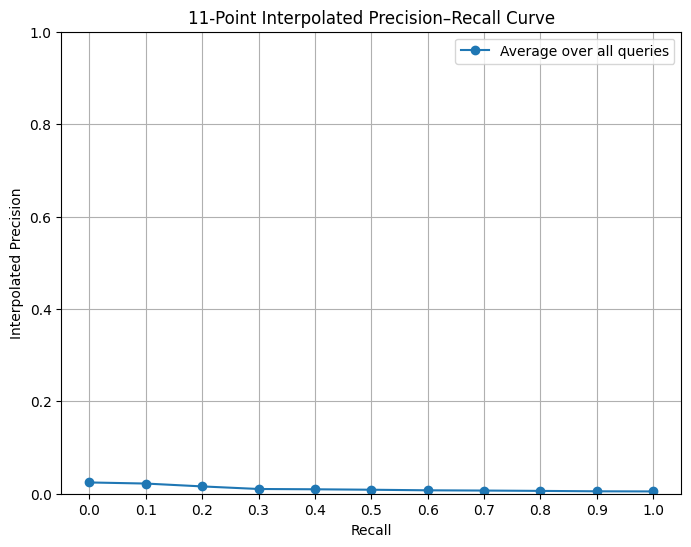

In [75]:

# TODO: Compute the 11-point interpolated precision–recall for each query

# Your code here

import numpy as np
import matplotlib.pyplot as plt

# Compute precision and recall at each rank for a single query
# retrieved: list of doc IDs returned by the model
# relevant: list of relevant doc IDs for this query
# Returns: (precisions, recalls)
def precision_recall_curve(retrieved, relevant):
  relevant_set = set(relevant) # Convert to set for faster lookup

  precisions = []
  recalls = []

  num_relevant_found = 0
  total_relevant = len(relevant_set)

  # Loop over retrieved documents, keeping track of rank
  for rank, doc_id in enumerate(retrieved, start=1):
    if doc_id in relevant_set:
      num_relevant_found += 1
    precision = num_relevant_found / rank
    recall = num_relevant_found / total_relevant if total_relevant > 0 else 0.0
    precisions.append(precision)
    recalls.append(recall)

  return precisions, recalls

# Compute interpolated precision for 11 standard recall levels
def interpolated_precision(precisions, recalls):

  recall_levels = np.linspace(0.0, 1.0, 11) # Standard 11 recall levels
  interpolated = []

  # Loop over each standard recall level
  for r in recall_levels:
    # Find all precision values where recall >= r
    p_max = max([p for p, rc in zip(precisions, recalls) if rc >= r], default=0.0) # If no recall >= r, default to 0.0
    interpolated.append(p_max) # maximum precision for this recall level

  return recall_levels, interpolated

# Compute averaged interpolated precision across all queries

# Prepare retrieved and relevant lists
all_retrieved = [results[qid] for qid in sorted(results.keys())]
all_relevant = [qrels[qid] for qid in sorted(results.keys())]

# Compute interpolated precision for each query
all_interpolated = []
for retrieved, relevant in zip(all_retrieved, all_relevant):
    precisions, recalls = precision_recall_curve(retrieved, relevant)
    _, interpolated = interpolated_precision(precisions, recalls)
    all_interpolated.append(interpolated)

# Average interpolated precision across queries
avg_interpolated = np.mean(all_interpolated, axis=0)

# Display numeric values for the 11-point curve
for r, p in zip(np.linspace(0.0, 1.0, 11), avg_interpolated):
    print(f"Recall {r:.1f}: Interpolated Precision = {p:.4f}")

plt.figure(figsize=(8,6))
plt.plot(np.linspace(0.0, 1.0, 11), avg_interpolated, marker='o', label="Average over all queries")
plt.xlabel("Recall")
plt.ylabel("Interpolated Precision")
plt.title("11-Point Interpolated Precision–Recall Curve")
plt.grid(True)
plt.ylim(0, 1)
plt.xticks(np.linspace(0.0, 1.0, 11))
plt.legend()
plt.show()

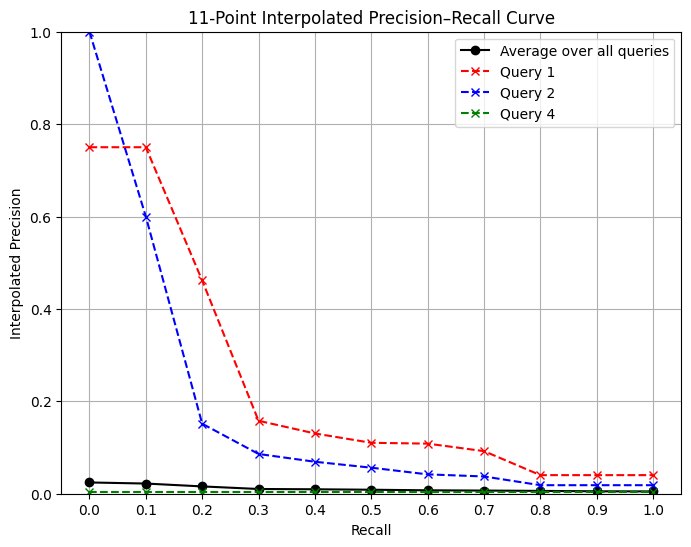

In [76]:
# The first 3 queries for individual plots
sample_qids = sorted(results.keys())[:3]

sample_curves = {}
recall_levels = np.linspace(0.0, 1.0, 11)

for qid in sample_qids:
    precisions, recalls = precision_recall_curve(results[qid], qrels[qid])
    _, interpolated = interpolated_precision(precisions, recalls)
    sample_curves[qid] = interpolated

plt.figure(figsize=(8,6))

# Average curve
plt.plot(recall_levels, avg_interpolated, marker='o', color='black', label="Average over all queries")

# Individual sample queries
colors = ['red', 'blue', 'green']
for color, (qid, curve) in zip(colors, sample_curves.items()):
    plt.plot(recall_levels, curve, marker='x', linestyle='--', color=color, label=f"Query {qid}")

plt.xlabel("Recall")
plt.ylabel("Interpolated Precision")
plt.title("11-Point Interpolated Precision–Recall Curve")
plt.grid(True)
plt.ylim(0, 1)
plt.xticks(recall_levels)
plt.legend()
plt.show()